**Introduction:**

*The dataset chosen for the Data Labelling Project with respect to Active Learning is* ***German Traffic Sign Based Recognition Dataset*** *and is downloaded from Kaggle.*

*The main purpose of the project is to identify the traffic signal images, which will be fed to the model and the model will let us know about the type of the image.*

**For example:** *if a Stop Traffic Signal Image is passed to the model then it should tell the user that it's a Stop sign.*


 **Kaggle.json** *is the json file downloaded from Kaggle which comprises of the key-value pairs of the username and the API-token of the user's account. *

In [ ]:
! pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


***Dataset Download and Unzipping:***

*In the next step, a part of the URL* (https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) *related to the dataset is being taken to download the dataset.*

*The datset is being downloaded and unzipped for the further use.*

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: barnana
Your Kaggle Key: ··········


100%|██████████| 612M/612M [00:02<00:00, 235MB/s]


***Importing all the necessary Libraries.***

In [ ]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from PIL import Image
import glob
import numpy as np
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from IPython.display import display
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten,Conv2D , MaxPool2D 
from keras.layers import Dropout
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

***Content of Dataset:***

1. *Post un-zipping the dataset we can see there are three folders available **Train, Test and Meta**. But we shall be dealing with Train and Test folders only.* 

2. Train folder Images will be used to to train the model, test folder Images will be used for cross-validation and Meta folder Images will be used for testing purpose.

2. *The train folder comprises of 43 subfolders and each subfolder has sets of images.The total count of Train Images is 39209.*

3. *The test folder comprises of only images with a total count of 12630.*

4. *The total count of train and test images is 51839.*

5. *The data related to each Image is available in Train.csv and Test.csv files.*


***Image Features***

*On reading the Train.csv and Test.csv files we can see the below features :*



1.   Width - The width of a particular image.
2.   Height - The height of a particular image.
3.   Roi.X1: X-coordinate of top-left corner of traffic sign bounding box.
4. Roi.Y1: Y-coordinate of top-left corner of traffic sign bounding box.
5. Roi.X2: X-coordinate of bottom-right corner of traffic sign bounding box.
6. Roi.Y2: Y-coordinate of bottom-right corner of traffic sign bounding box.
7. ClassId - The class a particular image is associated with.
8. Path - The path of the Image.





In [ ]:
df_train = pd.read_csv("//content/gtsrb-german-traffic-sign/Train.csv",dtype=str)
print(df_train.shape)
display(df_train.head(5))

df_test = pd.read_csv("/content/gtsrb-german-traffic-sign/Test.csv",dtype=str)
print(df_test.shape)
display(df_test.head(5))

df_meta = pd.read_csv("/content/gtsrb-german-traffic-sign/Meta.csv",dtype=str)
print(df_meta.shape)
display(df_meta.head(5))

(39209, 8)


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


(12630, 8)


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


(43, 5)


,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [ ]:
unqiue_train_class = len(pd.unique(df_train['ClassId']))
print("The total unique classes in Train dataset is : " + str(unqiue_train_class))
unqiue_test_class = len(pd.unique(df_test['ClassId']))
print("The total unique classes in Test dataset is : " + str(unqiue_train_class))

The total unique classes in Train dataset is : 43
The total unique classes in Test dataset is : 43


***Addition of New Column : SignNames***

*There are total 43 different classses and for each class we have seperate set of images. On further exploring I could get the Signal Names from online resource with respect to each category. Stored the same in the dictionary SignNames.*

*Hence, added another column in the dataframe with Column name SignNames for each row for both Train and Test dataset.* 

*For example: if the ClassId is 0 for a particular row then the value for SignNames column shall be Speed limit (20km/h).*

In [ ]:
SignNames = { 0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)', 2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 7:'Speed limit (100km/h)', 8:'Speed limit (120km/h)', 9:'No passing', 
            10:'No passing veh over 3.5 tons', 11:'Right-of-way at intersection', 12:'Priority road', 13:'Yield', 
            14:'Stop', 15:'No vehicles', 16:'Veh > 3.5 tons prohibited', 17:'No entry', 
            18:'General caution', 19:'Dangerous curve left', 20:'Dangerous curve right', 
            21:'Double curve', 22:'Bumpy road', 23:'Slippery road', 24:'Road narrows on the right', 
            25:'Road work', 26:'Traffic signals', 27:'Pedestrians', 28:'Children crossing', 
            29:'Bicycles crossing', 30:'Beware of ice/snow', 31:'Wild animals crossing', 
            32:'End speed + passing limits', 33:'Turn right ahead', 34:'Turn left ahead', 
            35:'Ahead only', 36:'Go straight or right', 37:'Go straight or left', 38:'Keep right', 
            39:'Keep left', 40:'Roundabout mandatory', 41:'End of no passing', 42:'End no passing veh > 3.5 tons'}

df_train['SignNames']=df_train['ClassId'].astype(int)
for i in tqdm(range(len(df_train))):
    value = SignNames.get(int(df_train['SignNames'][i]))
    df_train.loc[i,'SignNames'] = value
display(df_train.head(5))

df_test['SignNames']=df_test['ClassId'].astype(int)
for i in tqdm(range(len(df_test))):
    value = SignNames.get(int(df_test['SignNames'][i]))
    df_test.loc[i,'SignNames'] = value
display(df_test.head(5))

y_train = df_train['ClassId']
y_test = df_test['ClassId']
print(y_train.shape, y_test.shape)

100%|██████████| 39209/39209 [00:33<00:00, 1174.92it/s]


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,SignNames
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,Dangerous curve right
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,Dangerous curve right
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,Dangerous curve right
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,Dangerous curve right
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,Dangerous curve right


100%|██████████| 12630/12630 [00:04<00:00, 2619.45it/s]


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,SignNames
0,53,54,6,5,48,49,16,Test/00000.png,Veh > 3.5 tons prohibited
1,42,45,5,5,36,40,1,Test/00001.png,Speed limit (30km/h)
2,48,52,6,6,43,47,38,Test/00002.png,Keep right
3,27,29,5,5,22,24,33,Test/00003.png,Turn right ahead
4,60,57,5,5,55,52,11,Test/00004.png,Right-of-way at intersection


(39209,) (12630,)


***Below are the set of 36 images which shows the variety of images available in our Train dataset.***

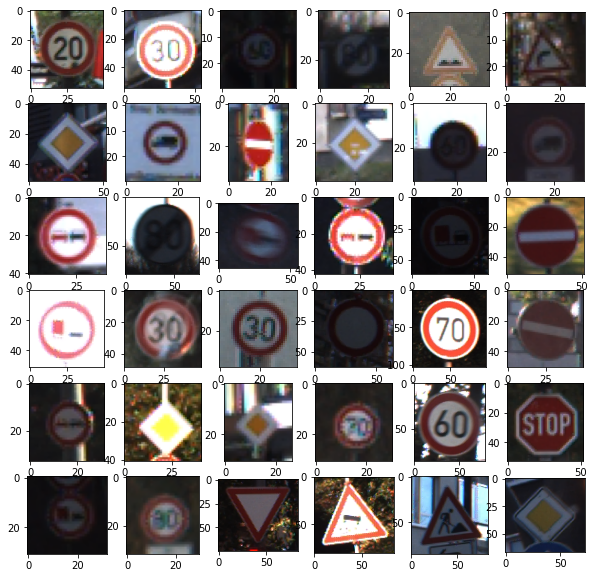

In [ ]:
#Below code let us define the size of the plot.
plt.rcParams["figure.figsize"] = (10,10)
for i in range(36):
  plt.subplot(6,6,i+1)
  #randomly we have selected 36 images among all the train images and have plotted the same.
  #Syntax : plt.imshow(plt.imread(full path))
  plt.imshow(plt.imread('/content/gtsrb-german-traffic-sign/'+df_train['Path'][np.random.randint(30000)]))

***Below are the set of 36 images which shows the variety of images available in our Test dataset.***

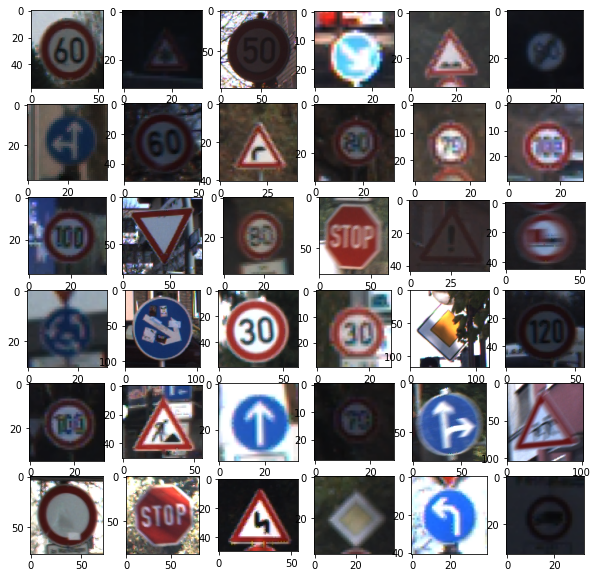

In [ ]:
#Below code let us define the size of the plot.
plt.rcParams["figure.figsize"] = (10,10)
for i in range(36):
  plt.subplot(6,6,i+1)
  #randomly we have selected 36 images among all the test images and have plotted the same.
  #Syntax : plt.imshow(plt.imread(full path))
  plt.imshow(plt.imread('/content/gtsrb-german-traffic-sign/'+df_test['Path'][np.random.randint(10000)]))

***Data Distribution:***

*Next, tried to check the count of images with respect to each class labels. The same was performed for both Train and Test data.*

*On exploring we have the below observations:*

1. *Both Train and Test dataset is imbalanced.*
2. *The train and test dataset has the highest set of Images for the Class ID 2 and its corresponidng Class Label is* **Speed limit (50km/h)**.
3. *The train dataset has the lowest set of Images for the Class ID 37 and its corresponidng Class Label is* **Go straight or left**.
4. *The test dataset has the lowest set of Images for the Class ID 27 and its corresponidng Class Label is* **Pedestrians**.
4. *The maximum amount of Image in train dataset for Class ID 2 is 2250.*
5. *The minimum amount of Image in train dataset  for Class ID 37 is 210.*
6. *The maximum amount of Image in test dataset for Class ID 2 is 750.*
5. *The minimum amount of Image in test dataset  for Class ID 27 is 60.*

In [ ]:
plot_order = df_train.groupby('SignNames')['SignNames'].count().sort_values(ascending=False)
print('Traffic Sign with maximum images.')
display(plot_order.head(1))
print("\n")
print('Traffic Sign with minimum images.')
display(plot_order.tail(1))

Traffic Sign with maximum images.


SignNames
Speed limit (50km/h)    2250
Name: SignNames, dtype: int64



Traffic Sign with minimum images.


SignNames
Go straight or left    210
Name: SignNames, dtype: int64

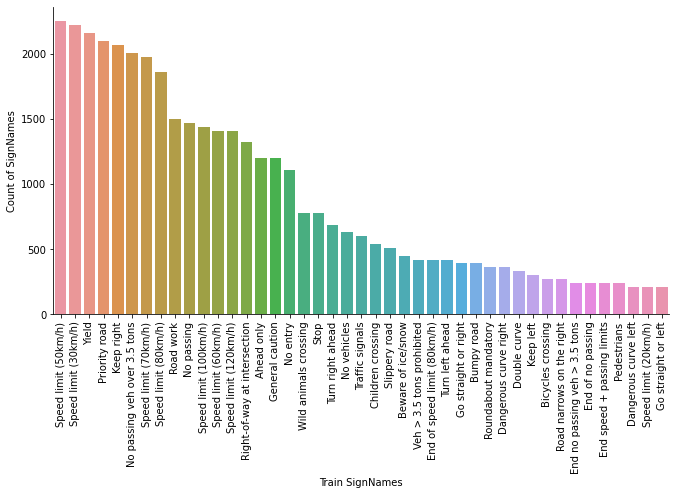

In [ ]:
plot_order = df_train.groupby('SignNames')['SignNames'].count().sort_values(ascending=False).index.values
sns.catplot(x="SignNames", kind="count", data=df_train,height=5, aspect=2,order=plot_order)
plt.xticks(rotation=90)
plt.xlabel("Train SignNames")
plt.ylabel("Count of SignNames")
plt.show()

In [ ]:
plot_order_test = df_test.groupby('SignNames')['SignNames'].count().sort_values(ascending=False)
print('Traffic Sign with maximum images.')
display(plot_order_test.head(1))
print("\n")
print('Traffic Sign with maximum images.')
display(plot_order_test.tail(1))

Traffic Sign with maximum images.


SignNames
Speed limit (50km/h)    750
Name: SignNames, dtype: int64



Traffic Sign with maximum images.


SignNames
Pedestrians    60
Name: SignNames, dtype: int64

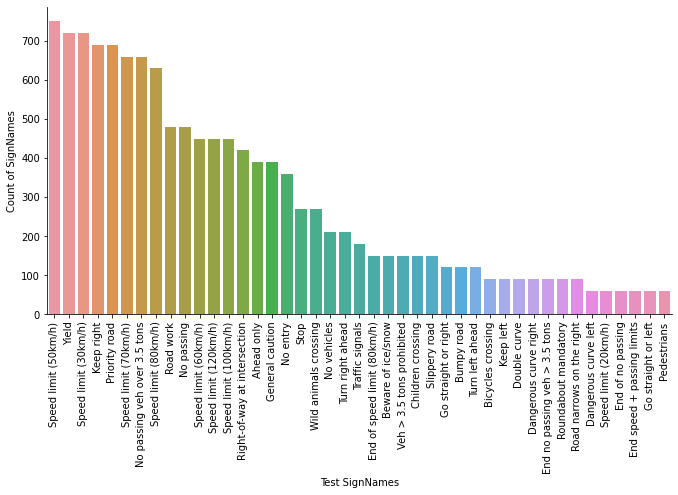

In [ ]:
plot_order_test = df_test.groupby('SignNames')['SignNames'].count().sort_values(ascending=False).index.values
sns.catplot(x="SignNames", kind="count", data=df_test,height=5, aspect=2,order=plot_order_test)
plt.xticks(rotation=90)
plt.xlabel("Test SignNames")
plt.ylabel("Count of SignNames")
plt.show()

***Bounding Boxes with ROI feature:***

*The below code gets 4 images and draws a Bounding Box with respect to ROI given for each Image in the dataset.*

1.   *First it displays the 4 rows/records chosen.*
2.   *Next, it displays the image with Bounding Boxes in the subplot.*

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,SignNames
22243,95,88,8,8,86,80,13,Train/13/00013_00059_00013.png,Yield


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,SignNames
9654,49,49,6,5,44,44,5,Train/5/00005_00040_00024.png,Speed limit (80km/h)


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,SignNames
14764,42,42,6,5,37,37,9,Train/9/00009_00040_00004.png,No passing


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,SignNames
24054,123,122,10,11,113,112,16,Train/16/00016_00000_00024.png,Veh > 3.5 tons prohibited


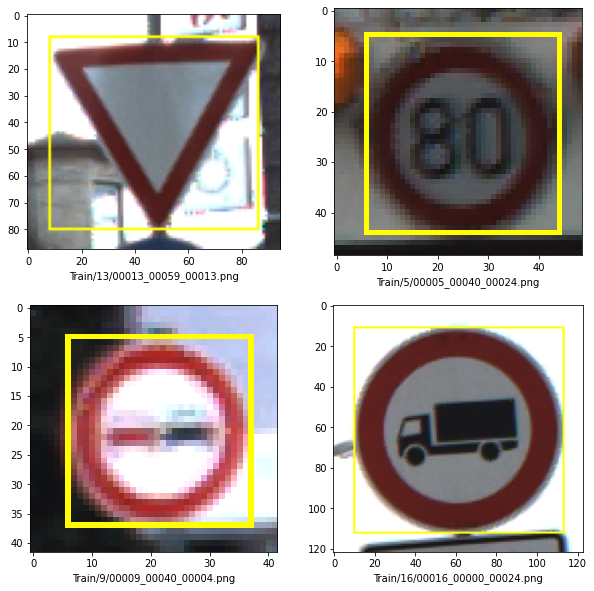

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
for i in range(0,4):
  plt.subplot(2,2,i+1)
  j = np.random.randint(30000)
  display(df_train.iloc[[j]])
  # reading the input image
  img = read_image('/content/gtsrb-german-traffic-sign/'+ df_train['Path'][j])
  
  # bounding box in (xmin, ymin, xmax, ymax) format
  # top-left point=(xmin, ymin), bottom-right point = (xmax, ymax)
  bbox = [int(df_train['Roi.X1'][j]),int(df_train['Roi.Y1'][j]),int(df_train['Roi.X2'][j]),int(df_train['Roi.Y2'][j])]
  bbox = torch.tensor(bbox, dtype=torch.int)
  bbox = bbox.unsqueeze(0)
  # draw bounding box on the input image
  img=draw_bounding_boxes(img, bbox, width=1, colors=(255,255,0))
  # transform it to PIL image and display
  img = torchvision.transforms.ToPILImage()(img)
  plt.xlabel(df_train['Path'][j])
  plt.imshow(img)

***Image Pre-Processing Steps - Phase 1 - Re-Size:***



1. *First we shall open each Image for both Train and Test dataset.*
2. *Then resize the same into (32,32) pixels.*





***Image Pre-Processing Steps - Phase 2 - Normalize:***

3.   *Post resizing, all the images are normalized in order to get all the Image in the range of 0 to 1.*
4.  *Below we can see that for train dataset we have 39209 images and each is (32,32) pixels with 3 channels i.e. RGB.*
5.  *Below we can see that for test dataset we have 12630 images and each is (32,32) pixels with 3 channels i.e. RGB.*


***Image Pre-Processing Steps - Phase 3 - Dimension Expansion:***

1. *In the below piece of code we can see that post normalization we have* (32,32) *pixel image with RGB=3 (i.e. the image is a colour image)*. 

2. *Next we have expanded the dimension and we can see 4 values in the tuple.*

     *(1,32,32,3) - 1 implies the number of images since we are dealing with one image so 1. Next is (32,32) pixel and RGB=3.*

3. *We have expanded the dimension because when we feed our Images to CNN model, then the model expectes the first parameter to be the number of images.* 

   *For example : if we have 1000 images then the shape shall be (1000,32,32,3).*

In [ ]:
def ImagePreprocessing(filename):
  #Read Image and Resize.
  im=Image.open(filename)
  if(im.mode == "RGBA"):
    im = im.convert("RGB")
  im=im.resize((32,32))
  im =np.array(im)

  #Normalizing the iamges and bringing it to a scale between 0 to 1
  train_norm_output = im.astype('float32')
  train_norm_output /= 255

  #Expanding the dimension to (1,32,32,3)
  sample_images_output = expand_dims(train_norm_output, 0)
  return sample_images_output

In [ ]:
for i in tqdm(range(len(df_train))):
  for filename in glob.glob('/content/gtsrb-german-traffic-sign/' + df_train['Path'][i]): 
    if i==0:
      train_input = ImagePreprocessing(filename)
    else:
      a = ImagePreprocessing(filename)
      train_input = np.append(train_input, a, axis = 0)
print(train_input.shape)


for i in tqdm(range(len(df_test))):
  for filename in glob.glob('/content/gtsrb-german-traffic-sign/' + df_test['Path'][i]): 
    if i==0:
      test_input = ImagePreprocessing(filename)
    else:
      a = ImagePreprocessing(filename)
      test_input = np.append(test_input, a, axis = 0)
print(test_input.shape)

100%|██████████| 39209/39209 [46:50<00:00, 13.95it/s]


(39209, 32, 32, 3)


100%|██████████| 12630/12630 [05:31<00:00, 38.09it/s]

(12630, 32, 32, 3)


***Image Agumentation***

Below set of code are the steps for Image Agumentation where a particular image is being taken into consideration and multiple images are created out of the single image.

Suppose we have a **STOP** Traffic Sign image then with Data Agumentation techniques we are going to make changes in a particular image with respect to various features such as horizontal flip, width_shift_range, height_shift_range etc. .

All related info can be found in the link : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator .

***Benefits of agumentation:***



1.   Create more Images out of one Image thereby making the model robust.
2.   Since our dataset is imbalanced, Data agumentation helps creating more images for classes with less images.
3. Since we shall be using all agumented images for data modelling our model becomes prone to noisy images and can detect any image easily.

***Keras ImageDataGenerator***

*We are using Keras ImageDataGenerator for Image Agumentation process. Below we have implemented for a single image to check its properties.*

1. *The features we are adding to the image are : rotation, width shift, height shift, zoom , horizontal flip and fill_mode is chosen as constant so that only the required image section is being  highlighted and the rest remains black.*

2. *We are taking the batch size as 5, which implies that 5 images shall be created post one run.*

3. *Next, we are creating Agumented folder and storing the data to the path /content/Agumented just for cehcking purpose, but we wont do the same when we will be feeding it to the CNN model because storing such huge set of images is not worthy.*

4. *We are saving the format as png and also adding a prefix as AUG.*

5. *Finally we are plotting the images in a subplot. We are generateing 36 images with the help of iterator and plottting the same for visual interpretaion.*

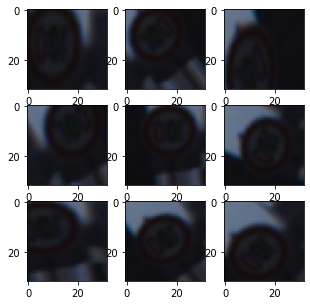

In [ ]:
k = np.random.randint(30000)
#for the selected image expanding the dimension.
sample_images = expand_dims(train_input[k], 0)

# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=90,width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.2,horizontal_flip=True,zoom_range=[0.5,1.0])
#we are using flow because here we are experimenting only with single image.
#batch_size=5 implies that 5 images shall be created post one run.
it = datagen.flow(sample_images, batch_size=5, save_to_dir='/content/',save_format='png', save_prefix='AUG',)

# generate sample images and plot
plt.rcParams["figure.figsize"] = (5,5)
plt.title("Images Post Agumentation")
for i in range(9):
    plt.subplot(3,3,i+1)
    # generate batch of images
    batch = it.next()
    image = batch[0];
    # plot raw pixel data
    plt.imshow(image)

In [ ]:
num_classes = 43
# convert to one hot encoing 
import tensorflow as tf
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 
print(train_input.shape)
print(test_input.shape)
print(y_train.shape)
print(y_test.shape)

(39209, 32, 32, 3)
(12630, 32, 32, 3)
(39209, 43)
(12630, 43)


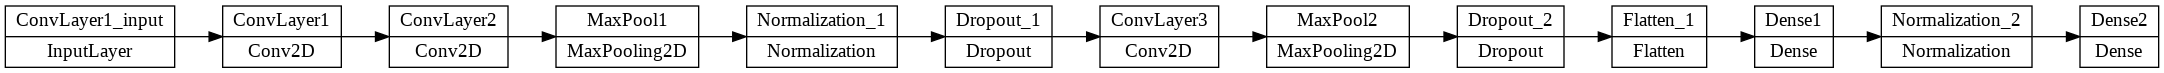

In [ ]:
def create_model():
  model =Sequential()
  model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',name="ConvLayer1", input_shape=(32,32,3)))
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',name="ConvLayer2"))
  model.add(MaxPool2D(pool_size=(2, 2),name="MaxPool1"))
  model.add(Normalization(name="Normalization_1"))
  model.add(Dropout(0.5,name="Dropout_1"))

  model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu',name="ConvLayer3"))
  model.add(MaxPool2D(pool_size=(2, 2),name="MaxPool2"))
  model.add(Dropout(0.5,name="Dropout_2"))

  model.add(Flatten(name="Flatten_1"))
  model.add(Dense(512, activation='relu',name="Dense1"))
  model.add(Normalization(name="Normalization_2"))
  model.add(Dense(43, activation='softmax',name="Dense2"))
  model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer= tf.keras.optimizers.Adam(),metrics=['accuracy'])
  return model

# Create a new model instance
model_1 = create_model()
plot_model(model_1, to_file='model.png',  rankdir='LR')

In [ ]:
import datetime, os

#The training wll be stopped if the validation accuracy did not increase in last 2 epochs.
earlystop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.01, patience=2, verbose=1)

#Train the model
datagen = ImageDataGenerator(rotation_range=90,width_shift_range=0.2, height_shift_range=0.2,fill_mode = "nearest",
                             shear_range=0.2,horizontal_flip=True,zoom_range=[0.5,1.0])

history = model_1.fit(datagen.flow(train_input, y_train, batch_size = 32),validation_data = (test_input, y_test), 
                      steps_per_epoch = len(train_input) // 32,epochs = 15,callbacks=[earlystop])

# Re-evaluate the model
loss, acc = model_1.evaluate(test_input, y_test, verbose=2)
print("Model, accuracy: {:5.2f}%".format(100 * acc))

#Save the model
model_1.save('model_Latest.h5')

Epoch 1/15
1225/1225 [==============================] - 34s 18ms/step - loss: 2.5360 - accuracy: 0.2627 - val_loss: 2.0235 - val_accuracy: 0.3565
Epoch 2/15
1225/1225 [==============================] - 21s 17ms/step - loss: 1.7581 - accuracy: 0.4321 - val_loss: 1.6995 - val_accuracy: 0.4538
Epoch 3/15
1225/1225 [==============================] - 22s 18ms/step - loss: 1.4665 - accuracy: 0.5120 - val_loss: 1.6441 - val_accuracy: 0.4726
Epoch 4/15
1225/1225 [==============================] - 22s 18ms/step - loss: 1.3055 - accuracy: 0.5570 - val_loss: 1.4968 - val_accuracy: 0.5221
Epoch 5/15
1225/1225 [==============================] - 21s 17ms/step - loss: 1.1951 - accuracy: 0.5929 - val_loss: 1.5900 - val_accuracy: 0.5045
Epoch 6/15
1225/1225 [==============================] - 21s 17ms/step - loss: 1.1143 - accuracy: 0.6165 - val_loss: 1.4486 - val_accuracy: 0.5411
Epoch 7/15
1225/1225 [==============================] - 23s 19ms/step - loss: 1.0478 - accuracy: 0.6389 - val_loss: 1.4786 -

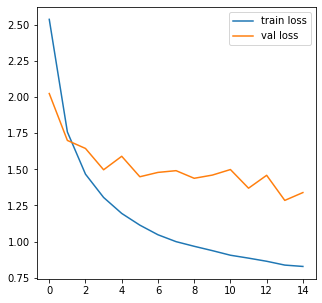

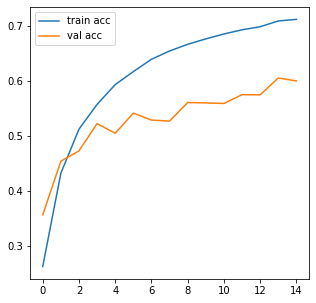

<Figure size 360x360 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

**Since the above model's accuracy is not much convincing hence changed few paramters and trained a new model.**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ConvLayer1 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 16, 16, 32)        0         
                                                                 
 Normalization1 (BatchNormal  (None, 16, 16, 32)       128       
 ization)                                                        
                                                                 
 Dropout1 (Dropout)          (None, 16, 16, 32)        0         
                                                                 
 ConvLayer2 (Conv2D)         (None, 16, 16, 128)       36992     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 8, 8, 128)         0         
                                                      

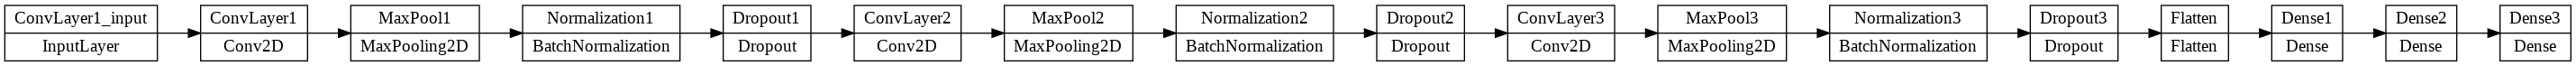

In [ ]:
def create_model_2():
  model =Sequential()
  #ConvLayer(32 filters) + MaxPooling + BatchNormalization + Dropout
  model.add(layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',name="ConvLayer1",input_shape=(32,32,3)))
  model.add(layers.MaxPool2D(strides=2,name="MaxPool1"))
  model.add(layers.BatchNormalization(name="Normalization1"))
  model.add(layers.Dropout(0.3,name="Dropout1"))

  #ConvLayer(128 filters) + MaxPooling + BatchNormalization + Dropout
  model.add(layers.Conv2D(filters=128,kernel_size=3,activation='relu',padding='same',name="ConvLayer2"))
  model.add(layers.MaxPool2D(strides=2,name="MaxPool2"))
  model.add(layers.BatchNormalization(name="Normalization2"))
  model.add(layers.Dropout(0.3,name="Dropout2"))

  #ConvLayer(512 filters) + Dropout + ConvLayer(512 filters) + MaxPooling + BatchNormalization
  model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same',name="ConvLayer3"))
  model.add(layers.MaxPool2D(strides=2,name="MaxPool3"))
  model.add(layers.BatchNormalization(name="Normalization3"))
  model.add(layers.Dropout(0.3,name="Dropout3"))

  model.add(layers.Flatten(name="Flatten"))
  model.add(layers.Dense(4000,activation='relu',name="Dense1"))
  model.add(layers.Dense(1000,activation='relu',name="Dense2"))
  model.add(layers.Dense(43,activation='softmax',name="Dense3"))
  model.summary()
  model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
  return model

# Create a new model instance
model_2 = create_model_2()
plot_model(model_2, to_file='model.png',  rankdir='LR')


In [ ]:
#The training wll be stopped if the validation accuracy did not increase in last 2 epochs.
earlystop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.01, patience=2, verbose=1)

history_2 = model_2.fit(datagen.flow(train_input, y_train, batch_size = 32),validation_data = (test_input, y_test), 
                      steps_per_epoch = len(train_input) // 32,epochs = 20,callbacks=[earlystop])

# Re-evaluate the model
loss_2, acc_2 = model_2.evaluate(test_input, y_test, verbose=2)
print("Model, accuracy: {:5.2f}%".format(100 * acc_2))

#Save the model
model_2.save('model_2_Latest.h5')

Epoch 1/20
1225/1225 [==============================] - 23s 18ms/step - loss: 2.3479 - accuracy: 0.3236 - val_loss: 1.9091 - val_accuracy: 0.3915
Epoch 2/20
1225/1225 [==============================] - 23s 19ms/step - loss: 1.5072 - accuracy: 0.4960 - val_loss: 1.5768 - val_accuracy: 0.4975
Epoch 3/20
1225/1225 [==============================] - 22s 18ms/step - loss: 1.2375 - accuracy: 0.5712 - val_loss: 1.6486 - val_accuracy: 0.5002
Epoch 4/20
1225/1225 [==============================] - 21s 17ms/step - loss: 1.1021 - accuracy: 0.6217 - val_loss: 1.5321 - val_accuracy: 0.5371
Epoch 5/20
1225/1225 [==============================] - 22s 18ms/step - loss: 1.0060 - accuracy: 0.6519 - val_loss: 1.4035 - val_accuracy: 0.5864
Epoch 6/20
1225/1225 [==============================] - 23s 19ms/step - loss: 0.9207 - accuracy: 0.6846 - val_loss: 1.5850 - val_accuracy: 0.5642
Epoch 7/20
1225/1225 [==============================] - 21s 17ms/step - loss: 0.8633 - accuracy: 0.7029 - val_loss: 1.3205 -

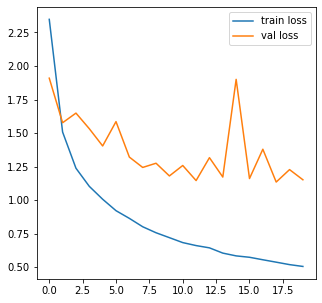

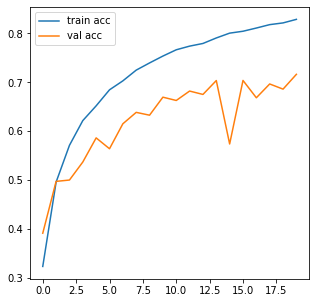

<Figure size 360x360 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history_2.history['loss'], label='train loss')
plt.plot(history_2.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history_2.history['accuracy'], label='train acc')
plt.plot(history_2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

**The accuracy is not much high but since we are implementing Active Learning the model performance shall increase accordingly.**

The Confidence Score is :100.0
17
No entry


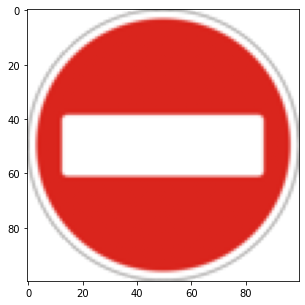

In [ ]:
from keras.models import load_model
plt.imshow(plt.imread('/content/gtsrb-german-traffic-sign/meta/17.png'))
sample_images_output = ImagePreprocessing('/content/gtsrb-german-traffic-sign/meta/17.png')
loaded_model_2 = load_model('model_2_Latest.h5')
y_pred_prob = loaded_model_2.predict(sample_images_output)
print("The Confidence Score is :" + str(np.max(y_pred_prob[0])*100))
print(np.argmax(y_pred_prob[0]))
print(SignNames[int(np.argmax(y_pred_prob[0]))])

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 5.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=9576bd74a3d2447316400bcc99d0acb127da569d3c533da0339a22c76cb230a9
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(sample_images_output[0].astype('double'), loaded_model_2.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

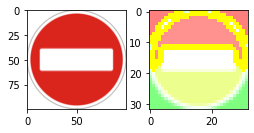

In [ ]:
from skimage.segmentation import mark_boundaries
image_list = []
image_list.append(plt.imread('/content/gtsrb-german-traffic-sign/meta/17.png'))
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, hide_rest=False, num_features=10)
image_list.append(mark_boundaries(temp_1/2+0.5, mask_1))

# temp_2, mask_2 =  explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, hide_rest=False, num_features=5)
# image_list.append(mark_boundaries(temp_2/2+0.5, mask_2))

# #Below code let us define the size of the plot.
plt.rcParams["figure.figsize"] = (4,4)
for i in range(2):
  plt.subplot(2,2,i+1)
  plt.imshow(image_list[i])

The model initially predicted wrong label for Pedestrians hence re-training the model by feeding a sett of 9 augmented images.

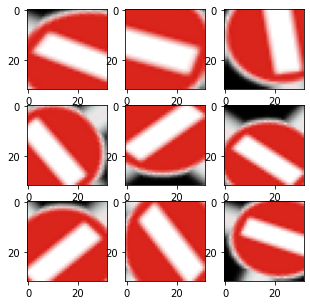

In [ ]:
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=90,width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.2,horizontal_flip=True,zoom_range=[0.5,1.0])
#we are using flow because here we are experimenting only with single image.
#batch_size=5 implies that 5 images shall be created post one run.
it = datagen.flow(sample_images_output, batch_size=5, save_to_dir='/content/Aug/',save_format='png', save_prefix='AUG')

# generate sample images and plot
plt.rcParams["figure.figsize"] = (5,5)
plt.title("Images Post Agumentation")
for i in range(9):
    plt.subplot(3,3,i+1)
    # generate batch of images
    batch = it.next()
    image = batch[0];
    # plot raw pixel data
    plt.imshow(image)

**Adding the Images and the corresponding lable to the train dataset.**

In [ ]:
y_train_new = np.zeros((1, 43))
y_train_new[0][27] = 1

for filename in glob.glob('/content/Aug/*.png'): 
    a = ImagePreprocessing(filename)
    train_input = np.append(train_input, a, axis = 0)
    y_train = np.append(y_train, y_train_new, axis=0)
print(train_input.shape,y_train.shape)

(39218, 32, 32, 3) (39218, 43)


In [ ]:
history_3 = loaded_model_2.fit(train_input, y_train, batch_size = 32, epochs = 5)
# Evaluate the model
loss_3, acc_3 = loaded_model_2.evaluate(test_input, y_test, verbose=2)
print("Model, accuracy: {:5.2f}%".format(100 * acc_2))
#Save the model
loaded_model_2.save('model_2_Latest.h5')

Epoch 1/5
1226/1226 [==============================] - 7s 5ms/step - loss: 0.1639 - accuracy: 0.9461
Epoch 2/5
1226/1226 [==============================] - 7s 5ms/step - loss: 0.0628 - accuracy: 0.9799
Epoch 3/5
1226/1226 [==============================] - 7s 5ms/step - loss: 0.0492 - accuracy: 0.9845
Epoch 4/5
1226/1226 [==============================] - 6s 5ms/step - loss: 0.0467 - accuracy: 0.9866
Epoch 5/5
1226/1226 [==============================] - 7s 6ms/step - loss: 0.0408 - accuracy: 0.9888
395/395 - 1s - loss: 0.3511 - accuracy: 0.9404 - 1s/epoch - 3ms/step
Model, accuracy: 71.63%


The Confidence Score is :99.89359974861145
24
Road narrows on the right


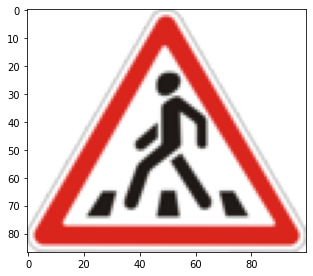

In [ ]:
plt.imshow(plt.imread('/content/gtsrb-german-traffic-sign/meta/27.png'))
sample_images_output = ImagePreprocessing('/content/gtsrb-german-traffic-sign/meta/27.png')
y_pred_prob = loaded_model_2.predict(sample_images_output)
print("The Confidence Score is :" + str(np.max(y_pred_prob[0])*100))
print(np.argmax(y_pred_prob[0]))
print(SignNames[int(np.argmax(y_pred_prob[0]))])

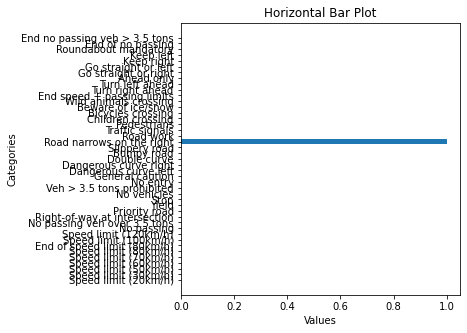

In [ ]:
val = list(SignNames.values())
plt.barh(val,y_pred_prob[0])
plt.xlabel("Values")
plt.ylabel('Categories')
plt.title('Horizontal Bar Plot')
plt.show()

**Upon re-training the model, now the model is predictig the label correctly. Below line of code is used to download the train set in form of .pkl files in order to further use it in Productionized Model.**

In [ ]:
import pickle
pickle.dump(train_input, open('/content/train_set.pkl', 'wb'))
pickle.dump(y_train, open('/content/y_train.pkl', 'wb'))

In [ ]:
train_set_pkl = pickle.load(open('/content/train_set.pkl', 'rb'))
print(train_set_pkl.shape)
y_train_pkl = pickle.load(open('/content/y_train.pkl', 'rb'))
print(y_train_pkl.shape)

(39218, 32, 32, 3)
(39218, 43)
